In [1]:
import os
import pandas as pd 
import matplotlib
from sklearn import linear_model
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import itertools as it
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from openpyxl.drawing.image import Image
from joblib import load
import shap
import warnings

sns.set_style("whitegrid")

# set project dir
from project_utils.envtools import set_project_dir
set_project_dir()

# set output dir
outdir = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/'
os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

#shap.initjs()

/global/home/reynaj/.conda/envs/py-starter/lib/python3.1/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_force_plot(explainer, shap_values, input_data, clinical_data, samples, sample_no, sample_name, title_loc='right'):

    fig = shap.plots.force(explainer.expected_value, shap_values.values[sample_no], input_data.iloc[sample_no], matplotlib = True, show=False)
    
    # add a title
    ax = fig.get_axes()[0]
    label = f'{sample_name}, '
    label += f'Diease Activity: {clinical_data.iloc[sample_no].disease_activity}, '
    label += f'Correct IBD: {clinical_data.iloc[sample_no].ibd_diagnosis}'
    ax.set_title(label, loc=title_loc)
    
    return(fig)

## Load the data

In [3]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.250_prots.npq.tsv", sep="\t")
protein_data = protein_data.T

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# keep the a virtual backup of the main clinical and protein data
backup_clinical_data = clinical_data.copy()
backup_protein_data = protein_data.copy()

# remove just visit 1 samples
keep = (clinical_data.event_name == 1.0).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
clinical_data = clinical_data.iloc[focus_idxs]
protein_data = protein_data.iloc[focus_idxs,:]

# # extract just CD and UC data
# focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
# # commented out on purpose, need all samples 
# clinical_data = clinical_data.iloc[focus_idxs]
# protein_data = protein_data.iloc[focus_idxs]

In [4]:
protein_data.head(3)

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245


In [5]:
clinical_data.head(3)

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease,1.0,Mild


In [6]:
print(protein_data.shape, clinical_data.shape)

(52, 250) (52, 18)


In [7]:
# load the model
model_fn = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/model.rfe_14_proteins.joblib'
model = load(model_fn)

In [8]:
model

LogisticRegression(max_iter=1000, random_state=0)

In [9]:
model_features = model.feature_names_in_

### SHAP Analyses Support Figure 3

In [10]:
# compute SHAP values
input_data = protein_data[model_features]
explainer = shap.LinearExplainer(model, input_data)
shap_values = explainer(input_data)

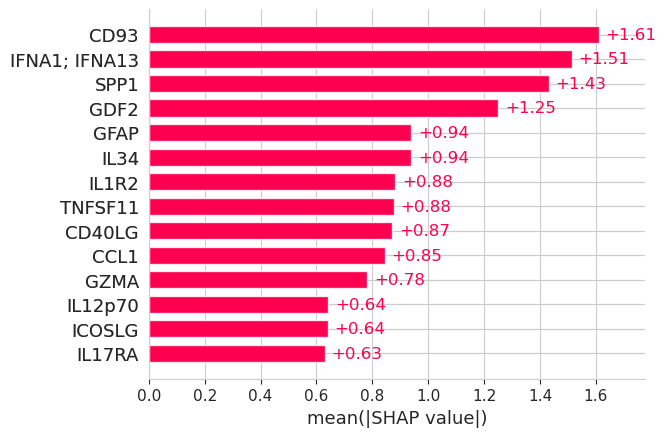

In [11]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values, max_display=20, ax=ax)

outfn = os.path.join(outdir, 'figure3.shap_barplot.svg')
fig.tight_layout()
fig.savefig(outfn)

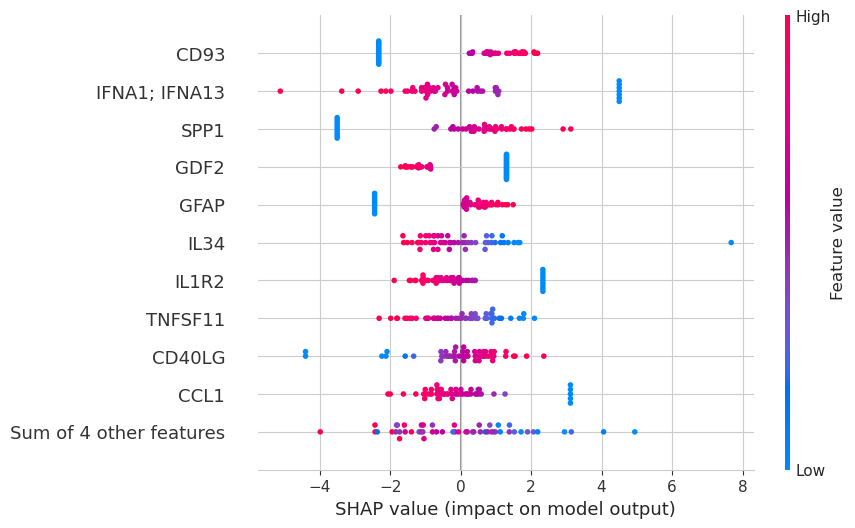

In [12]:
shap.plots.beeswarm(shap_values, max_display=11)

In [13]:
# expected_value = explainer.expected_value

# select = range(20)
# features = input_data
# features_display = model_features

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     shap_values = explainer.shap_values(features)[1]
#     shap_interaction_values = explainer.shap_interaction_values(features)
    
# if isinstance(shap_interaction_values, list):
#     shap_interaction_values = shap_interaction_values[1]

In [14]:
# # Plot decision plot for first few samples
# shap.decision_plot(
#     explainer.expected_value, shap_values, input_data
# )

### SHAP Analyses Support Figure 4

In [15]:
# remove just visit 1 samples
keep = (backup_clinical_data.event_name > 1.0).tolist()
post_v1_clinical_data = backup_clinical_data.loc[keep,:]
post_v1_protein_data = backup_protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(post_v1_clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
post_v1_clinical_data = post_v1_clinical_data.iloc[focus_idxs]
post_v1_protein_data = post_v1_protein_data.iloc[focus_idxs,:]

In [16]:
post_v1_clinical_data.shape

(22, 18)

In [17]:
post_v1_protein_data.shape

(22, 250)

In [18]:
# compute SHAP values
input_data = post_v1_protein_data[model_features]
explainer = shap.LinearExplainer(model, input_data, model_output='log_odds')
shap_values = explainer(input_data)

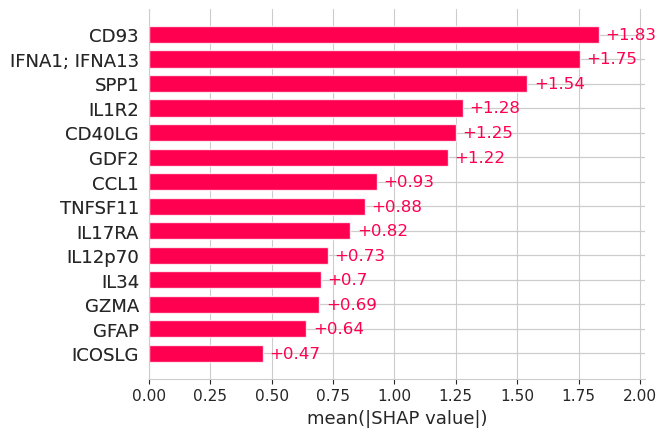

In [19]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values, max_display=20, ax=ax)

outfn = os.path.join(outdir, 'figure4.shap_barplot.svg')
fig.tight_layout()
fig.savefig(outfn)

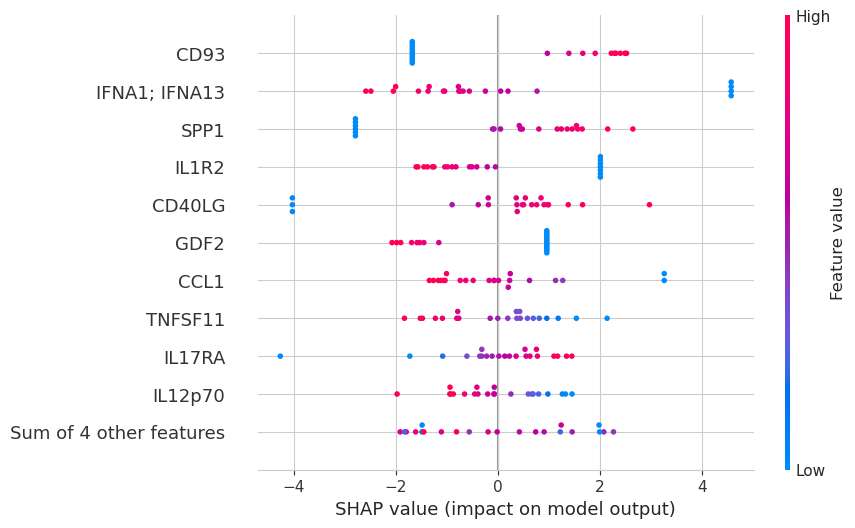

In [20]:
shap.plots.beeswarm(shap_values, max_display=11)

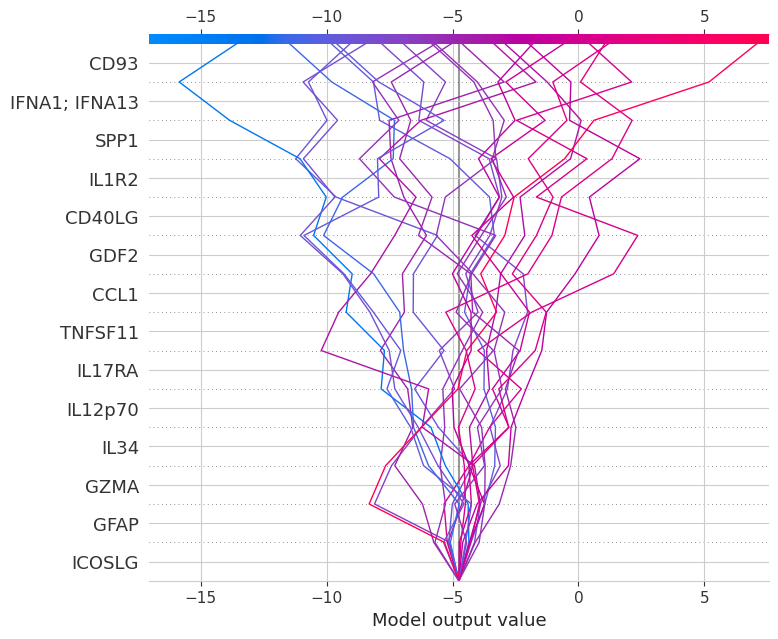

In [21]:
shap.decision_plot(explainer.expected_value, shap_values.values, input_data.columns)

In [22]:
model.classes_

array(['CD', 'UC'], dtype=object)

#### Force plots for one CD, UC, and one borderline 

In [23]:
def make_force_plot(explainer, shap_values, input_data, clinical_data, sample_no, sample_name, title_loc='right'):

    fig = shap.plots.force(explainer.expected_value, shap_values.values[sample_no], input_data.iloc[sample_no], matplotlib = True, show=False)
    
    # add a title
    ax = fig.get_axes()[0]
    label = f'{sample_name}, '
    label += f'Diease Activity: {clinical_data.iloc[sample_no].disease_activity}, '
    label += f'Correct IBD: {clinical_data.iloc[sample_no].ibd_diagnosis}'
    ax.set_title(label, loc=title_loc)
    
    return(fig)

In [24]:
samples = post_v1_clinical_data.sample_id.tolist()

In [25]:
final_log_odds = shap_values.base_values + shap_values.values.sum(axis=1)

In [26]:
final_log_odds

array([ -2.92579077,  -6.96373977,  -7.82643744,   0.4320285 ,
        -9.82670603,  -4.63409327,  -9.06821995, -13.57552145,
        -8.45313738, -11.48237779,  -3.36764841,   7.08895317,
        -1.81383193,  -0.57936969,  -1.9819232 ,  -5.0420165 ,
         1.04741121,  -5.66329732,  -5.83859047,  -9.61217801,
        -5.69956862,   1.20049788])

In [27]:
post_v1_clinical_data.loc[:, 'log_odds'] = final_log_odds
post_v1_clinical_sorted = post_v1_clinical_data.sort_values('log_odds')

In [28]:
post_v1_clinical_sorted

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity,log_odds
52,Byrd_IBD_Saliva_sup,Saliva,TRP-45552-1,2024-03-27 15:51:34.595,1.0,F3,1000.0,TRP-45552-1,2.0,CD,2024-03-27,Quiescent,8.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate,-13.575521
55,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-004-45568-1,2024-04-10 16:53:06.105,1.0,F6,1100.0,TRIANGLE PEDS-004-45568-1,2.0,CD,2024-04-10,Quiescent,4.0,NaN,IBD Super Group,In-active Disease,23.0,High,-11.482378
37,Byrd_IBD_Saliva_sup,Saliva,TRP-45523-5,2024-03-06 16:35:22.83,1.0,D8,1500.0,TRP-45523-5,2.0,CD,2024-03-06,Quiescent,23.0,NaN,IBD Super Group,In-active Disease,5.0,Moderate,-9.826706
78,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-004-48237-3,2024-06-12 16:30:02.347,1.0,H9,1100.0,TRIANGLE PEDS-004-48237-3,3.0,CD,2024-06-12,Mild,4.0,NaN,IBD Super Group,Active Disease,23.0,High,-9.612178
47,Byrd_IBD_Saliva_sup,Saliva,TRP-45547-1,2024-03-20 14:45:37.124,1.0,E8,1100.0,TRP-45547-1,2.0,CD,2024-03-20,Quiescent,28.0,NaN,IBD Super Group,In-active Disease,4.0,Moderate,-9.068220
54,Byrd_IBD_Saliva_sup,Saliva,TRP-45554-1,2024-03-27 15:51:34.595,1.0,F5,750.0,TRP-45554-1,2.0,CD,2024-03-27,Quiescent,5.0,NaN,IBD Super Group,In-active Disease,1.0,Mild,-8.453137
34,Byrd_IBD_Saliva_sup,Saliva,TRP-45517-1,2024-02-28 12:36:52.177,1.0,D5,1500.0,TRP-45517-1,2.0,CD,2024-02-28,Mild,31.0,NaN,IBD Super Group,Active Disease,49.0,High,-7.826437
30,Byrd_IBD_Saliva_sup,Saliva,TRP-42695-2,2024-02-21 16:50:10.535,1.0,D1,1300.0,TRP-42695-2,2.0,CD,2024-02-21,Quiescent,13.0,NaN,IBD Super Group,In-active Disease,1.0,Mild,-6.963740
77,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-021-48238-3,2024-06-12 16:30:02.347,1.0,H8,1700.0,TRIANGLE PEDS-021-48238-3,2.0,CD,2024-06-12,Quiescent,21.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate,-5.838590
79,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-003-48248-3,2024-06-19 15:23:17.322,1.0,H10,1050.0,TRIANGLE PEDS-003-48248-3,2.0,CD,2024-06-19,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild,-5.699569


In [29]:
# strong_cd = samples[np.argmin(final_log_odds)]
strong_cd_name = 'TRP-45552-1'
strong_cd = samples.index(strong_cd_name)

In [30]:
# strong_uc = samples[np.argmax(final_log_odds)]
strong_uc_name = 'TRIANGLE PEDS-042-48265-3'
strong_uc = samples.index(strong_uc_name)

In [31]:
# closest_to_zero = samples[np.argmin(np.abs(final_log_odds))]
closest_to_zero = np.argmin(np.abs(final_log_odds))

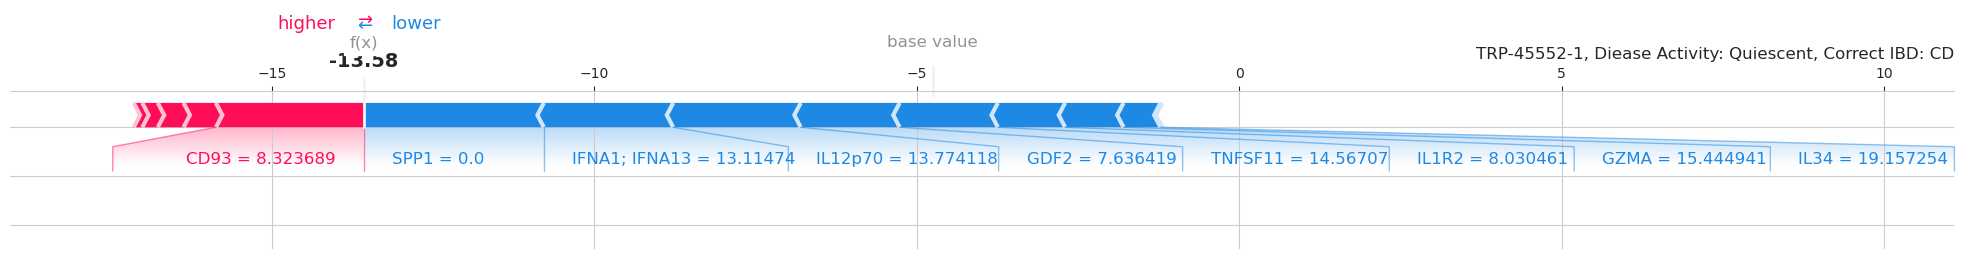

In [32]:
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, strong_cd, sample_name=strong_cd_name, title_loc='right')

# save the figure
output_fn = os.path.join(outdir, 'post_v1.strongest_cd_prediction.svg')
fig.tight_layout()
fig.savefig(output_fn)

fig

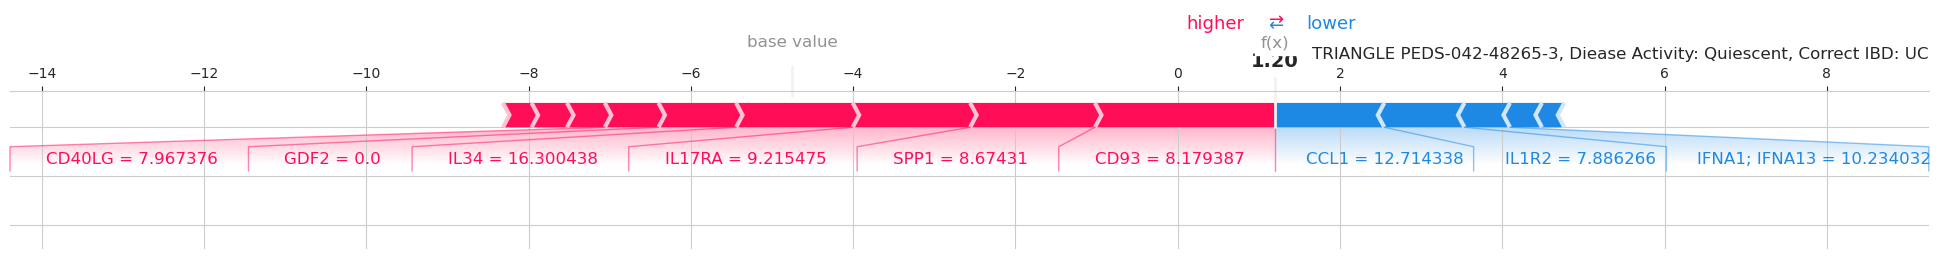

In [33]:
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, strong_uc, sample_name=strong_uc_name, title_loc='right')

# save the figure
output_fn = os.path.join(outdir, 'post_v1.strongest_uc_prediction.svg')
fig.tight_layout()
fig.savefig(output_fn)

fig

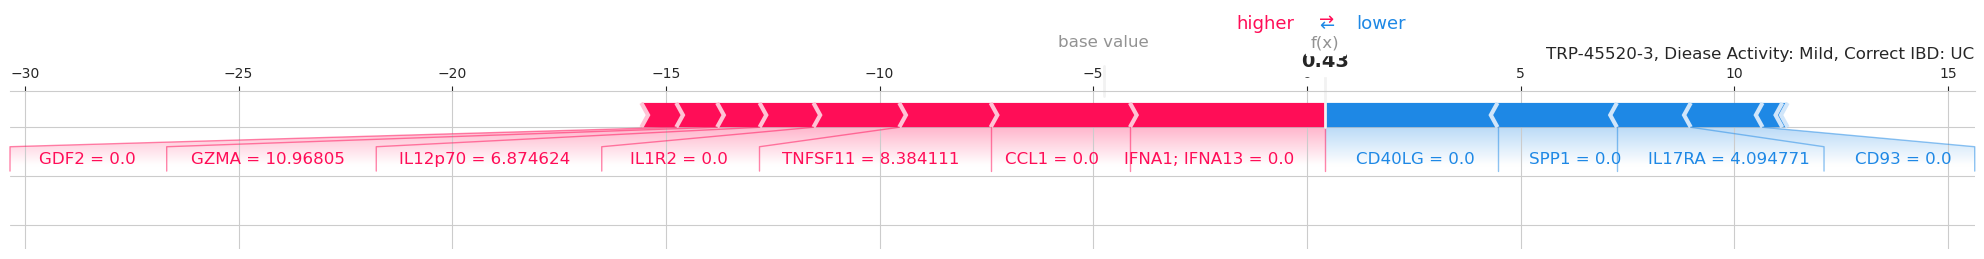

In [34]:
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, closest_to_zero, sample_name=samples[closest_to_zero], title_loc='right')

# save the figure
output_fn = os.path.join(outdir, 'post_v1.closest_to_zero_prediction.svg')
fig.tight_layout()
fig.savefig(output_fn)

fig

#### Force plots for misclassifications

In [35]:
pv1_missclass_samples = ['TRIANGLE PEDS-009-48226-3', 'TRP-42670',
                            'TRIANGLE PEDS-013-48225-3', 'TRIANGLE PEDS-042-48223-3']
pv1_missclass_indexes = sorted([post_v1_clinical_data.sample_id.tolist().index(x) for x in pv1_missclass_samples])

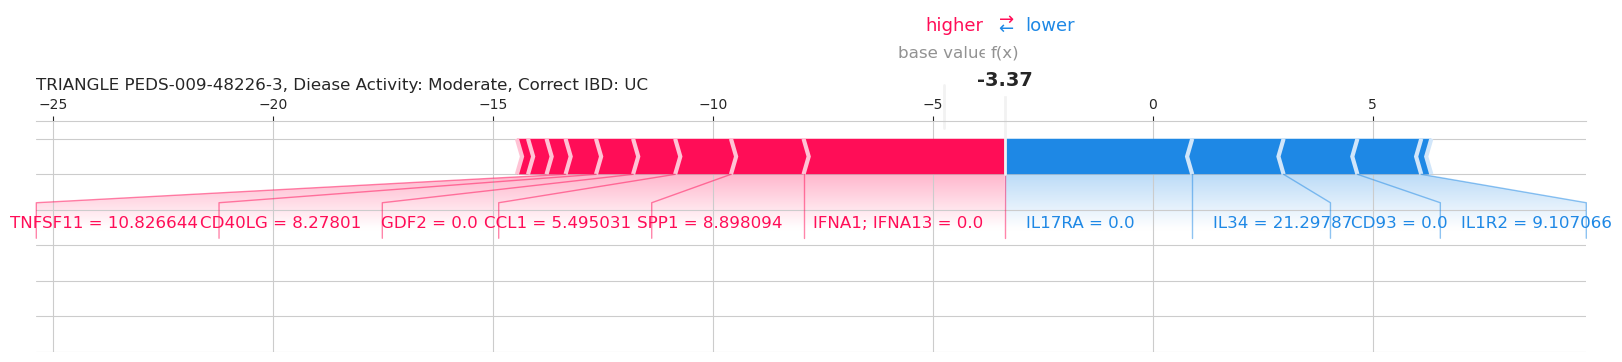

In [36]:
sample_name = pv1_missclass_samples[0]
sample_no = samples.index(sample_name)   
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, sample_no, sample_name, title_loc='left')

# # save the figure
# output_fn = os.path.join(outdir, 'post_v1.closest_to_zero_prediction.svg')
# fig.tight_layout()
# fig.savefig(output_fn)

fig

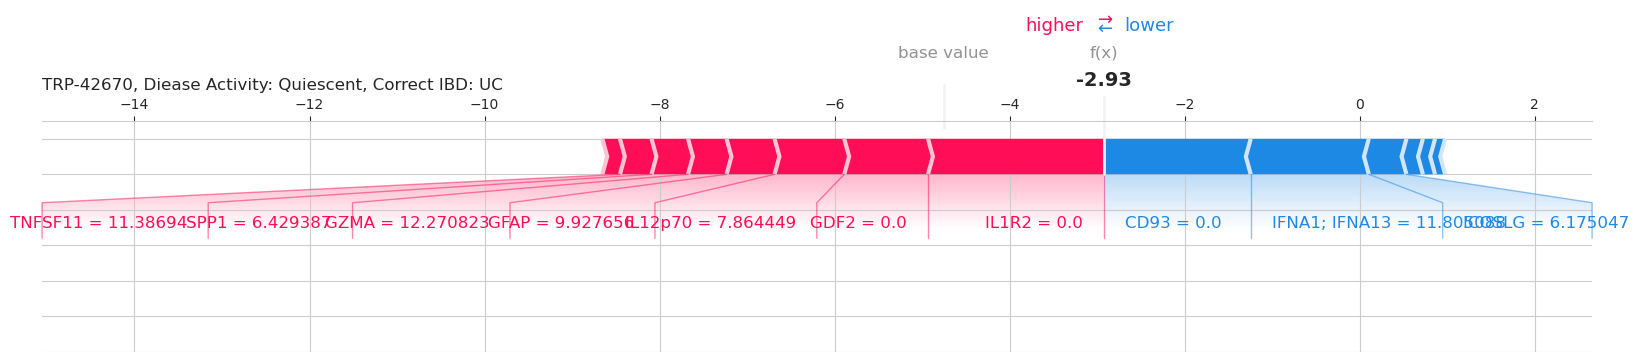

In [37]:
sample_name = pv1_missclass_samples[1]
sample_no = samples.index(sample_name)   
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, sample_no, sample_name, title_loc='left')

# # save the figure
# output_fn = os.path.join(outdir, 'post_v1.closest_to_zero_prediction.svg')
# fig.tight_layout()
# fig.savefig(output_fn)

fig

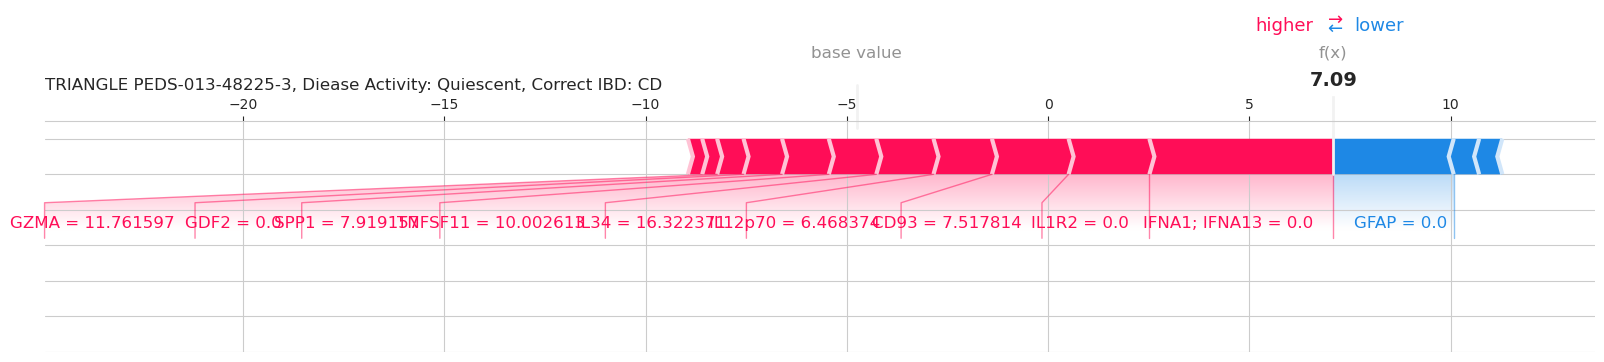

In [38]:
sample_name = pv1_missclass_samples[2]
sample_no = samples.index(sample_name)   
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, sample_no, sample_name, title_loc='left')

# # save the figure
# output_fn = os.path.join(outdir, 'post_v1.closest_to_zero_prediction.svg')
# fig.tight_layout()
# fig.savefig(output_fn)

fig

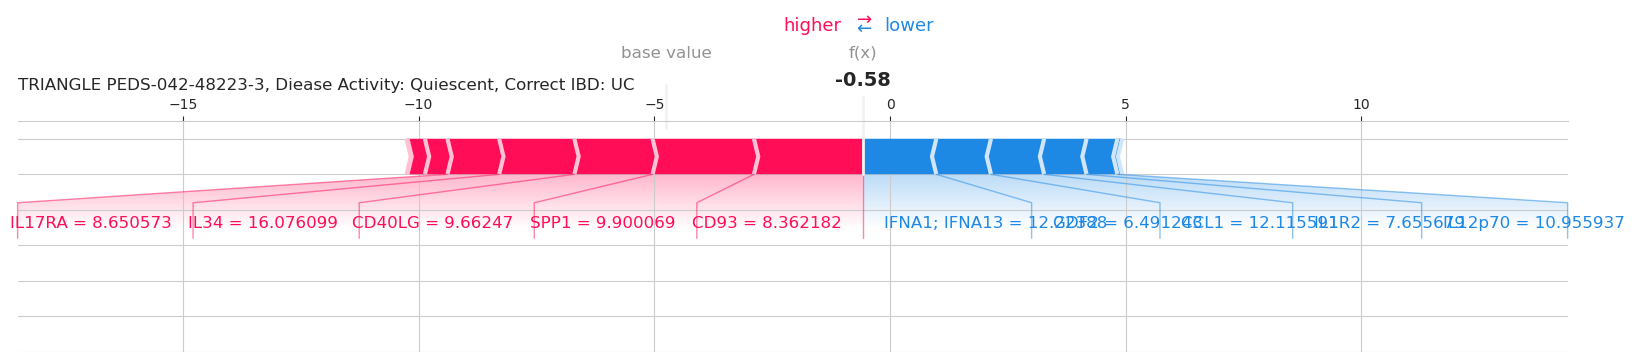

In [39]:
sample_name = pv1_missclass_samples[3]
sample_no = samples.index(sample_name)   
fig = make_force_plot(explainer, shap_values, input_data, post_v1_clinical_data, sample_no, sample_name, title_loc='left')

# # save the figure
# output_fn = os.path.join(outdir, 'post_v1.closest_to_zero_prediction.svg')
# fig.tight_layout()
# fig.savefig(output_fn)

fig

In [40]:
os.path.abspath(outfn)

'/global/home/reynaj/Projects/kevin_byrd/20241011.kevin_byrd.ibd_nulisa/results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/figure4.shap_barplot.svg'

### SHAP Analyses Support Figure 5

In [41]:
# extract just IBD-U data
focus_idxs = np.argwhere(backup_clinical_data['ibd_diagnosis'].isin(['IBD-U'])).reshape(-1)
ibdu_clinical_data = backup_clinical_data.iloc[focus_idxs]
ibdu_protein_data = backup_protein_data.iloc[focus_idxs,:]

In [42]:
ibdu_clinical_data.shape

(8, 18)

In [43]:
ibdu_protein_data.shape

(8, 250)

In [44]:
# compute SHAP values
input_data = ibdu_protein_data[model_features]
explainer = shap.LinearExplainer(model, input_data, model_output='log_odds')
shap_values = explainer(input_data)
samples = input_data.index.tolist()

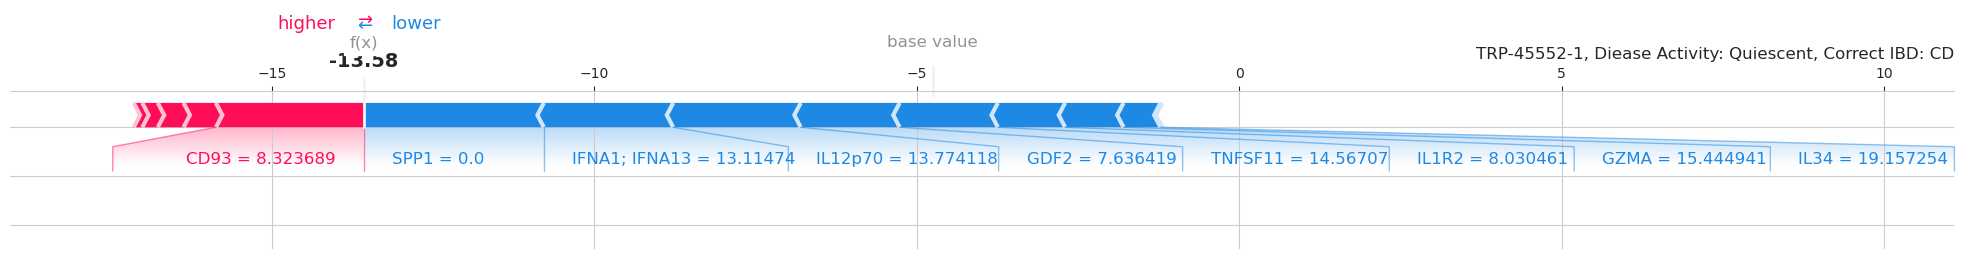

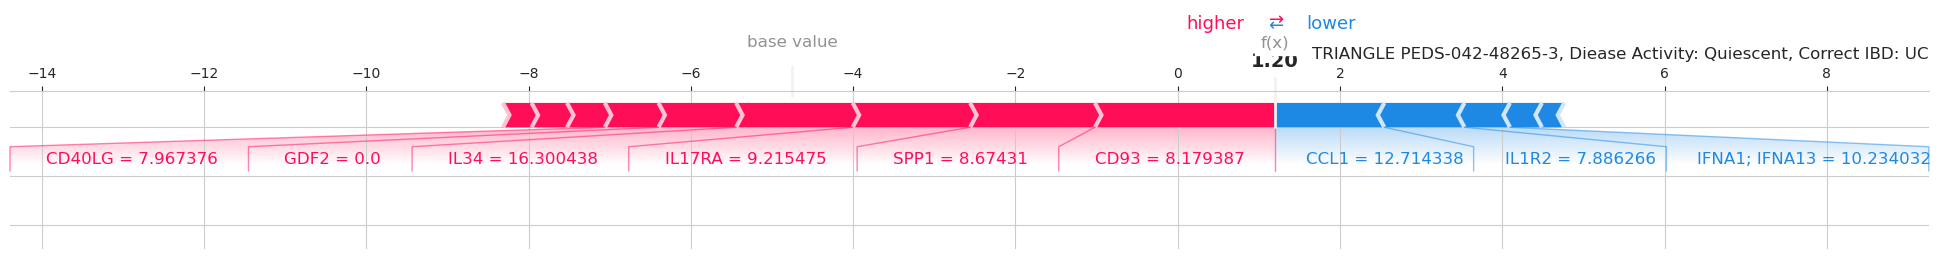

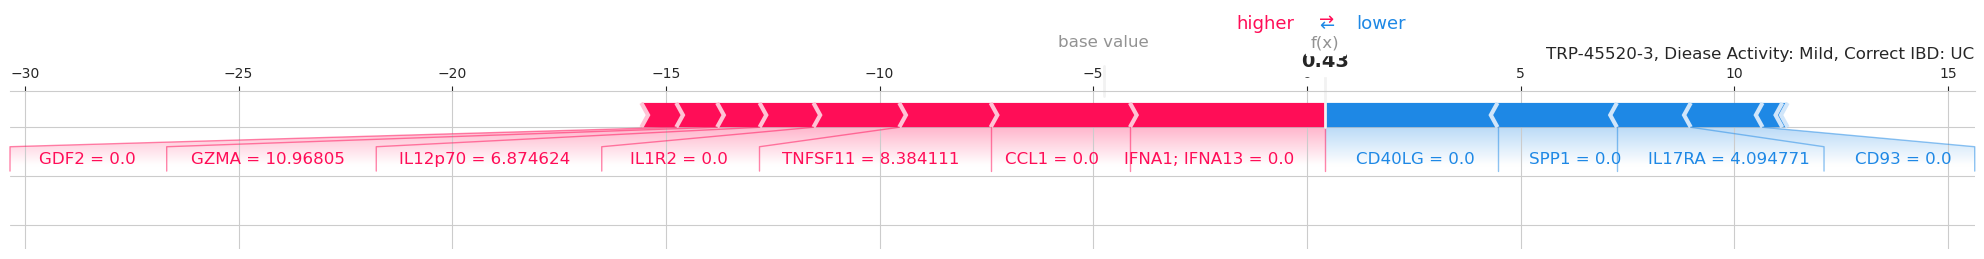

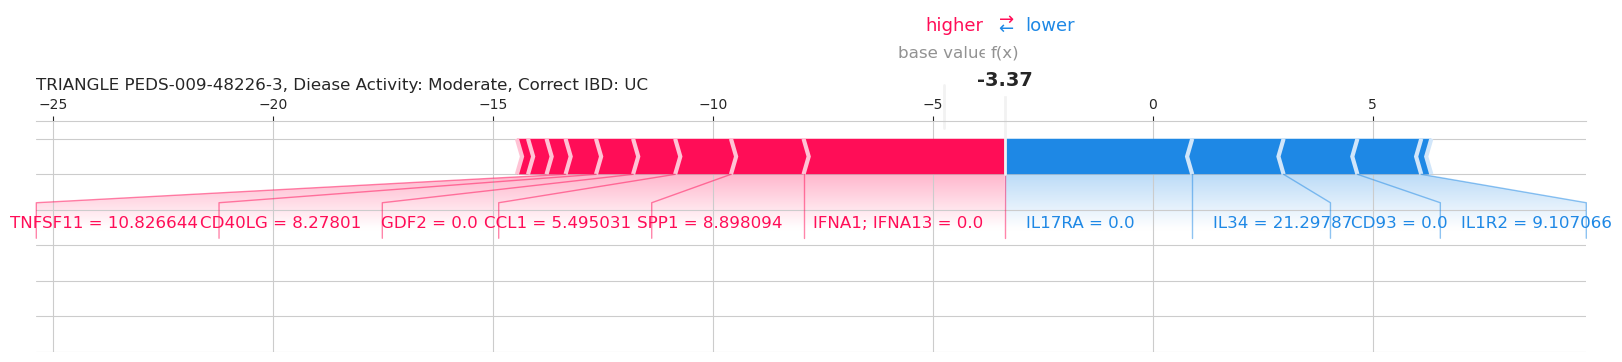

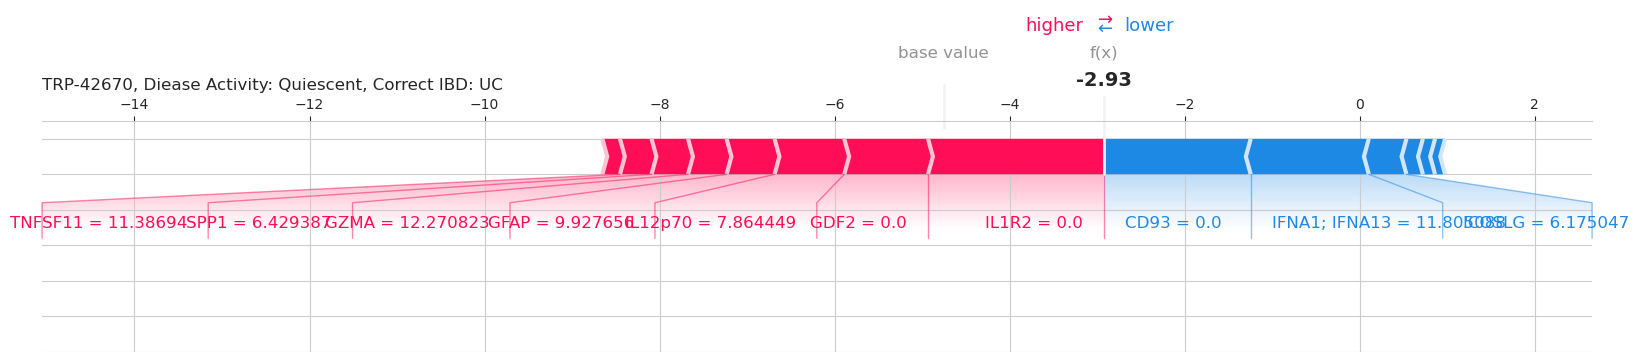

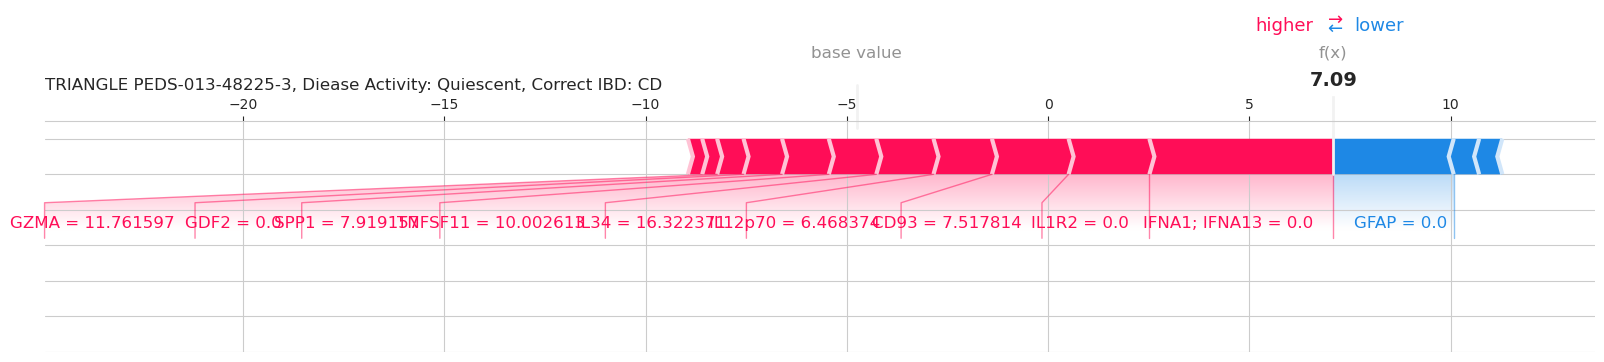

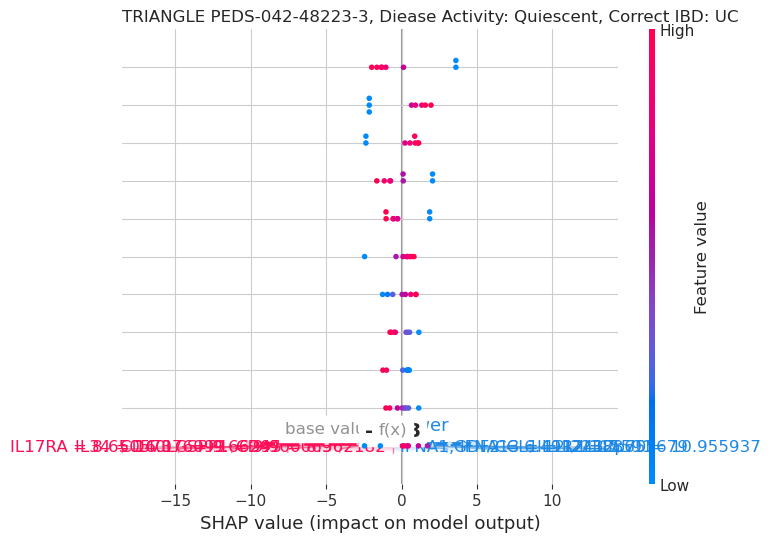

In [45]:
shap.plots.beeswarm(shap_values, max_display=11)

In [46]:
plt.clf()   # Clear current figure
plt.cla()   # Clear current axes (if needed)
plt.close() # Close the figure window completely

p = shap.decision_plot(explainer.expected_value, shap_values.values, input_data.columns, show=False, return_objects=True)

outfn = os.path.join(outdir, 'ibdu_preds.decision_plot.svg')
plt.savefig(outfn, bbox_inches='tight')

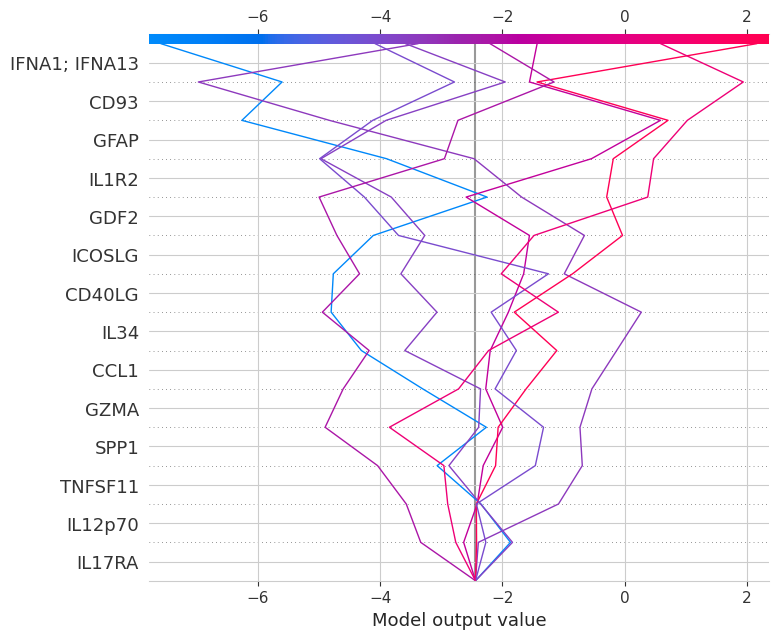

In [47]:
plt.clf(); plt.cla(); plt.close()
shap.decision_plot(explainer.expected_value, shap_values.values, input_data.columns, show=True, return_objects=False)

In [48]:
# for sample_no in range(input_data.shape[0]):
#     shap.plots.force(explainer.expected_value, shap_values.values[sample_no], input_data.iloc[sample_no], matplotlib = False)
#     break

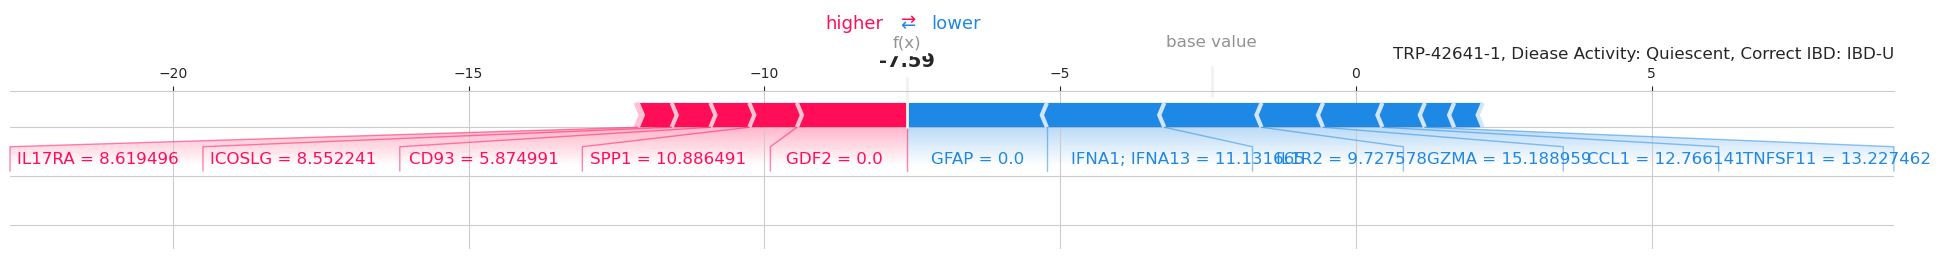

In [49]:
sample_no = 0
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')

# save the figure
output_fn = os.path.join(outdir, 'ibdu_preds.strongest_cd_prediction.svg')
fig.tight_layout()
fig.savefig(output_fn)

fig

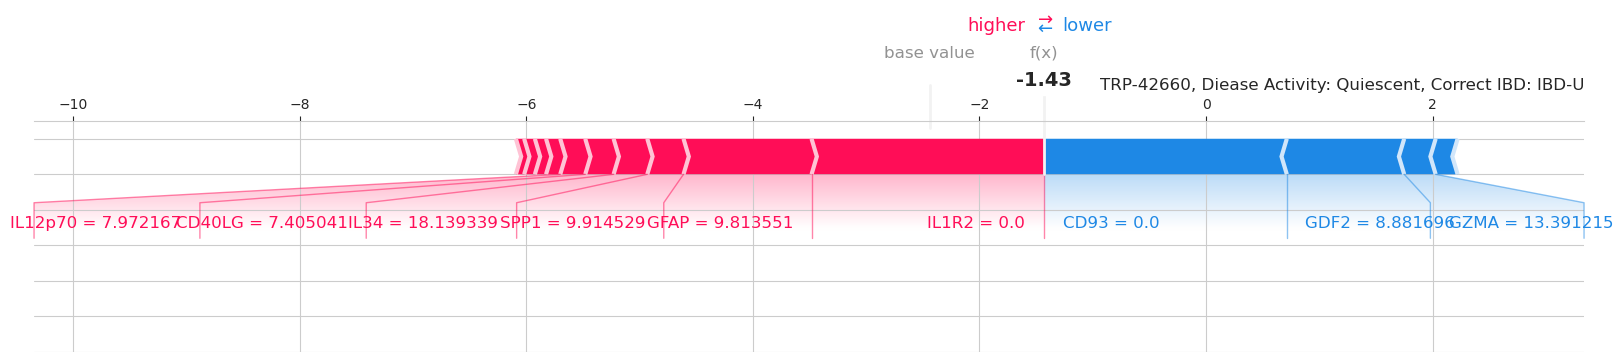

In [50]:
sample_no = 1
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')
fig

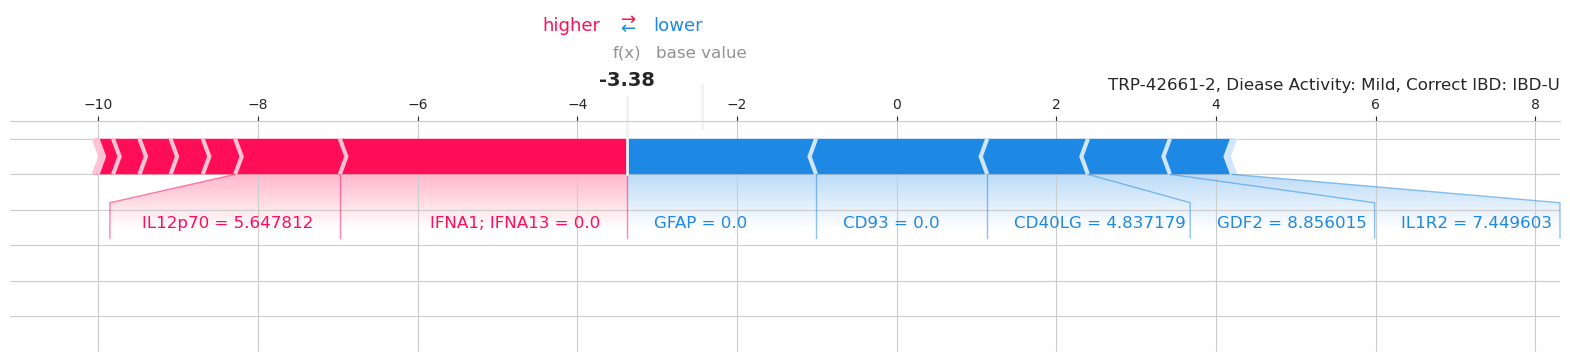

In [51]:
sample_no = 2
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')
fig

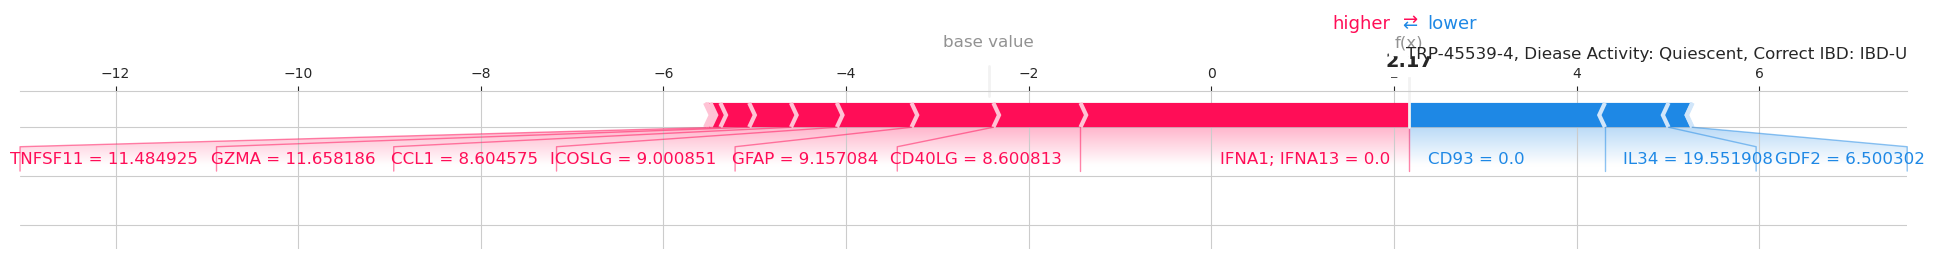

In [52]:
sample_no = 3
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')

# save the figure
output_fn = os.path.join(outdir, 'ibdu_preds.strongest_uc_prediction.svg')
fig.tight_layout()
fig.savefig(output_fn)

fig

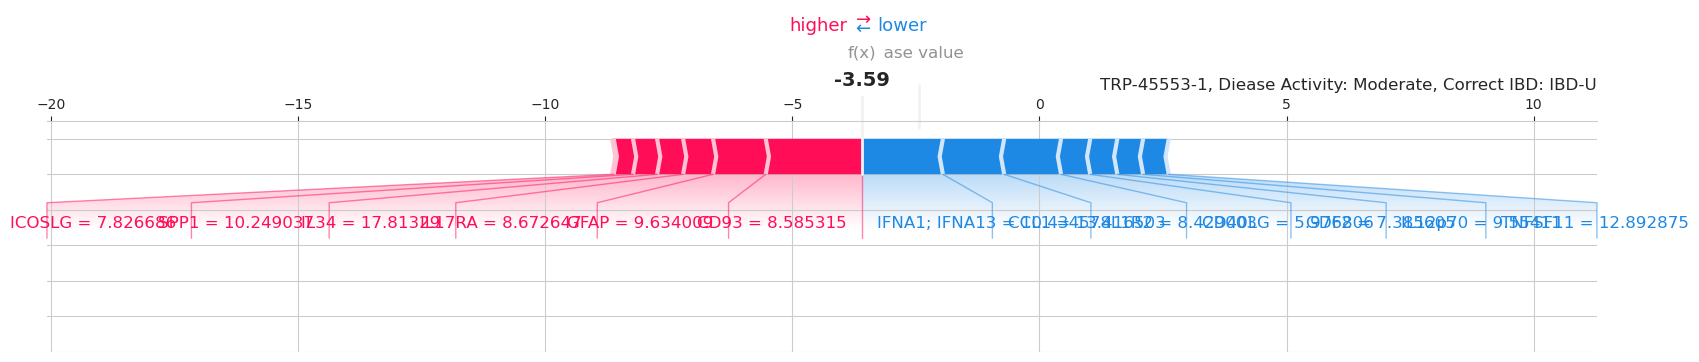

In [53]:
sample_no = 4
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')
fig

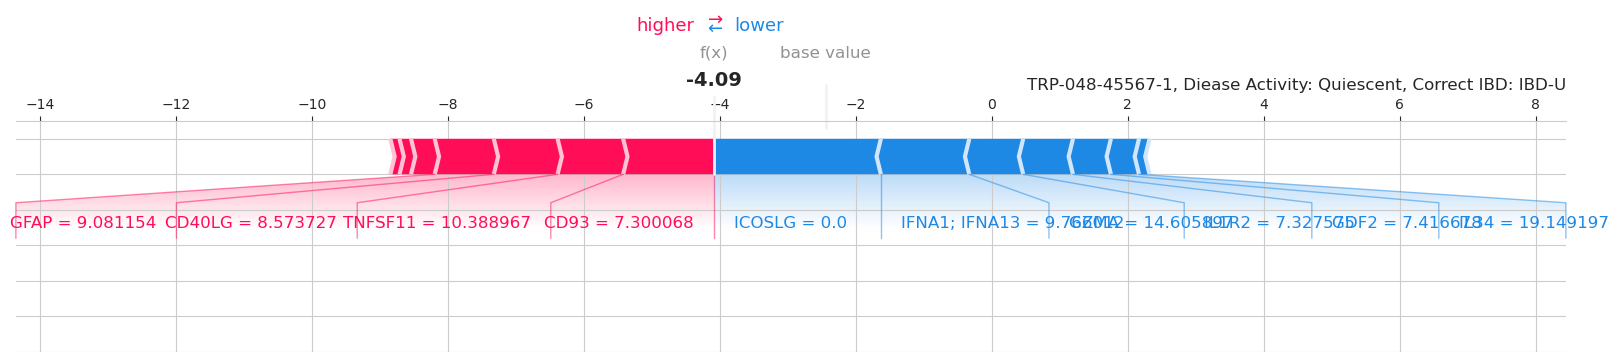

In [54]:
sample_no = 5
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')
fig

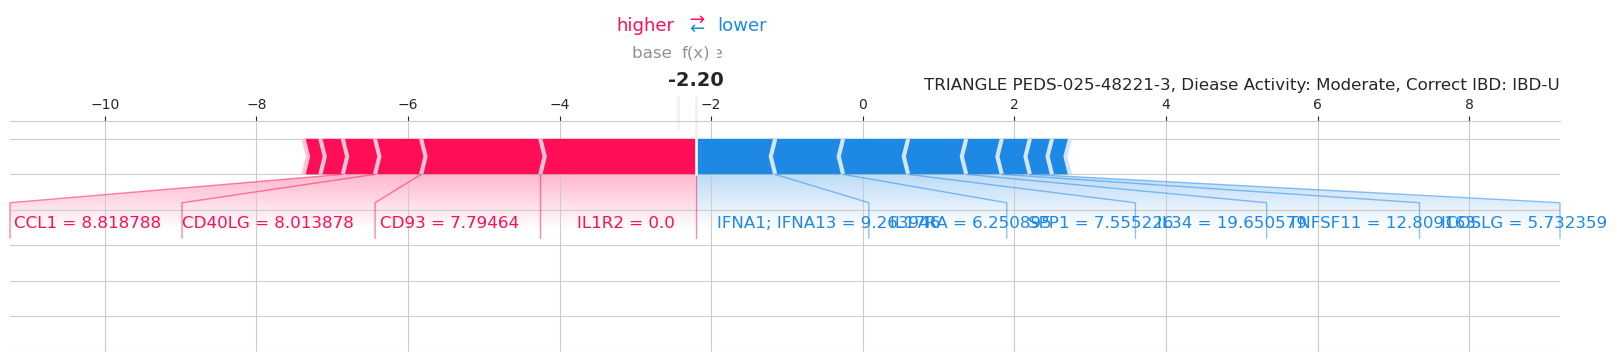

In [55]:
sample_no = 6
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')
fig

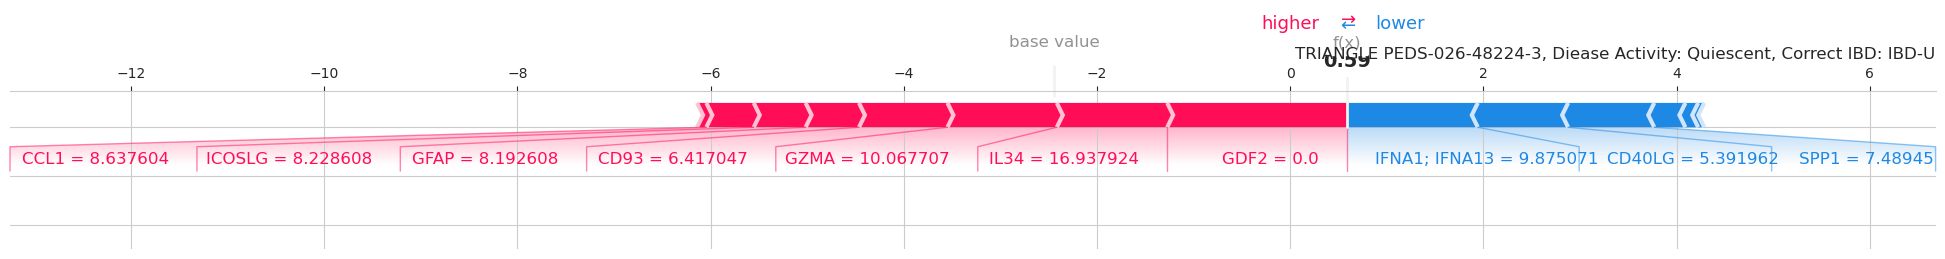

In [56]:
sample_no = 7
sample_name = samples[sample_no]
fig = make_force_plot(explainer, shap_values, input_data, ibdu_clinical_data, sample_no, sample_name, title_loc='right')

# save the figure
output_fn = os.path.join(outdir, 'ibdu_preds.closest_to_zero_prediction.svg')
fig.tight_layout()
fig.savefig(output_fn)

fig